In [1]:
import ctypes as ct

In [2]:
pxrd = ct.cdll.LoadLibrary("./pxrd.cpython-38-x86_64-linux-gnu")

OSError: ./pxrd.cpython-38-x86_64-linux-gnu: cannot open shared object file: No such file or directory

In [ ]:
%load_ext cython

In [ ]:
%%cython
def test(n):
    pass

In [ ]:
%%cython

import numpy as np
cimport numpy as np
cimport cython
from cython import boundscheck, wraparound
import math
from libc.math cimport sin as csin
from libc.math cimport cos as ccos
from libc.math cimport asin as casin
from libc.math cimport exp as cexp
import random
import glob
import tqdm

cdef double PI = math.pi
cdef double TWOPI = 2.0*PI
cdef double TAU = (1.0+math.sqrt(5))/2.0
cdef double CONST1 = 1.0/2.0/math.sqrt(TAU+2)
cdef double EPS = 1E-06

DTYPE_int = np.int64
DTYPE_double = np.float64
ctypedef np.int64_t DTYPE_int_t
ctypedef np.float64_t DTYPE_double_t

# Atomic structure factor
# New Analytical Scattering-Factor Functions for Free Atoms and  Ions, D. Waasamaier et.al)
cdef dict asf_parameters = {}
#asf_parameters['element'] = [a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, c]
asf_parameters['Mg'] = [4.708971, 4.875207, 1.194814, 108.5060, 1.558157, 0.111516, 1.170413, 48.292407, 3.239403, 1.928171, 0.126842]
asf_parameters['Al'] = [4.730796, 3.620931, 2.313951, 43.05116, 1.541980, 0.095960, 1.117564, 108.93231, 3.154754, 1.555918, 0.139509]
asf_parameters['Si'] = [5.275329, 2.631338, 3.191038, 33.73072, 1.511514, 0.081119, 1.356849, 86.288640, 2.519114, 1.170087, 0.145073]
asf_parameters['Ca'] = [8.593655, 10.46064, 1.477324, 0.041891, 1.436254, 81.39038, 1.182839, 169.84783, 7.113258, 0.688098, 0.196255]
asf_parameters['Sc'] = [1.476566, 53.13102, 1.487278, 0.035325, 1.600187, 137.3194, 9.177463, 9.098031, 7.099750, 0.602102, 0.157765]
asf_parameters['Ti'] = [9.818524, 8.001879, 1.522646, 0.029763, 1.703101, 39.885423, 1.768774, 120.158000, 7.082555, 0.532405, 0.102473]
asf_parameters['V']  = [10.47357, 7.081940, 1.547881, 0.026040, 1.986381, 31.909672, 1.865616, 108.022044, 7.056250, 0.474882, 0.067744]
asf_parameters['Cr'] = [11.00706, 6.366281, 1.555477, 0.023987, 2.985293, 23.244838, 1.347855, 105.774500, 7.034779, 0.429369, 0.065510]
asf_parameters['Mn'] = [11.70954, 5.597120, 1.733414, 0.017800, 2.673141, 21.788419, 2.023368, 89.517915, 7.003180, 0.383054, -0.147293]
asf_parameters['Fe'] = [12.31109, 5.009415, 1.876623, 0.014461, 3.066177, 18.743041, 2.070451, 82.767874, 6.975185, 0.346506, -0.304931]
asf_parameters['Co'] = [12.91451, 4.507138, 2.481908, 0.009126, 3.466894, 16.438130, 2.106351, 76.987317, 6.960892, 0.314418, -0.936572]
asf_parameters['Ni'] = [13.52186, 4.077277, 6.947285, 0.286763, 3.866028, 14.622634, 2.135900, 71.966078, 4.284731, 0.004437, -2.762697]
asf_parameters['Cu'] = [14.01419, 3.738280, 4.784577, 0.003744, 5.056806, 13.034982, 1.457971, 72.554793, 6.932996, 0.265666, -3.254477]
asf_parameters['Zn'] = [14.74100, 3.388232, 6.907748, 0.243315, 4.642337, 11.903689, 2.191766, 63.312130, 38.424042, 0.000397, -36.915828]
asf_parameters['Ga'] = [15.75894, 3.121754, 6.841123, 0.226057, 4.121016, 12.482196, 2.714681, 66.203622, 2.395246, 0.007238, -0.87395]
asf_parameters['Ge'] = [16.54061, 2.866618, 1.567900, 0.012198, 3.727829, 13.432163, 3.345098, 58.866046, 6.785079, 0.210974, 0.018726]
asf_parameters['As'] = [17.02564, 2.597739, 4.503441, 0.003012, 3.715904, 14.272119, 3.937200, 50.437997, 6.790175, 0.193015, -2.984117]
asf_parameters['Se'] = [17.35407, 2.349787, 4.653248, 0.002550, 4.259489, 15.579460, 4.136455, 45.181201, 6.749163, 0.177432, -3.160982]
asf_parameters['Sr'] = [17.73021, 1.563060, 9.795867, 14.31086, 6.099763, 0.1205740, 2.620025, 135.77131, 0.600053, 0.120574, 1.140251]
asf_parameters['Y']  = [17.79204, 1.429691, 10.25325, 13.132816, 5.714949, 0.112173, 3.170516, 108.197029, 0.918251, 0.112173, 1.131787]
asf_parameters['Zr'] = [17.05977, 1.310692, 10.91103, 12.319285, 5.821115, 0.104353, 3.512513, 91.777544, 0.746965, 0.104353, 1.124859]
asf_parameters['Nb'] = [17.95839, 1.211590, 12.06305, 12.246687, 5.007015, 0.098615, 3.287667, 75.011944, 1.531019, 0.098615, 1.123452]
asf_parameters['Mo'] = [6.236218, 0.090780, 17.98771, 1.108310, 12.973127, 11.468720, 3.451426, 66.684153, 0.210899, 0.090780, 1.108770]
asf_parameters['Tc'] = [17.84096, 1.005729, 3.428236, 41.901383, 1.373012, 119,320541, 12.947364, 9.781542, 6.335469, 0.083391, 1.074784]
asf_parameters['Ru'] = [6.271624, 0.077040, 17.90673, 0.928222, 14.123269, 9.555345, 3.746008, 35.860678, 0.908235, 123.552247, 1.043992]
asf_parameters['Rh'] = [6.216648, 0.070789, 17.91973, 0.856121, 3.854252, 33.889484, 0.840326, 121.686688, 15.173498, 9.029517, 0.995452]
asf_parameters['Pd'] = [6.121511, 0.062549, 4.784063, 0.784031, 16.631683, 8.751391, 4.318258, 34.489983, 13.246773, 0.784031, 0.883099]
asf_parameters['Ag'] = [6.073874, 0.055333, 17.15543, 7.896512, 4.173344, 28.443739, 0.852238, 110.376108, 17.988685, 0.716809, 0.756603]
asf_parameters['Cd'] = [6.080986, 0.048990, 18.01946, 7.273646, 4.018197, 29.119283, 1.303510, 95.831208, 17.974669, 0.661231, 0.605304]
asf_parameters['In'] = [6.196477, 0.042072, 18.81618, 6.695665, 4.050479, 31.009791, 1.638929, 103.284350, 17.962912, 0.610714, 0.333097]
asf_parameters['Sn'] = [19.32517, 6.118104, 6.281571, 0.036915, 4.498866, 32.529047, 1.856934, 95.037182, 17.917310, 0.565651, 0.119024]
asf_parameters['Sb'] = [5.394956, 33.32652, 6.549570, 0.030974, 19.650681, 5.564929, 1.827820, 87.130965, 17.867833, 0.523992, -0.290506]
asf_parameters['Te'] = [6.660302, 33.03165, 6.940756, 0.025750, 19.847015, 5.065547, 1.557175, 84.101613, 17.802427, 0.487660, -0.806668]
asf_parameters['Hf'] = [30.61703, 1.795613, 15.14535, 9.934469, 54.933548, 0.000739, 4.096253, 76.189707, 16.896157, 0.175914, -49.719838]
asf_parameters['Ta'] = [31.06635, 1.708732, 15.34182, 9.618455, 49.278296, 0.000760, 4.577665, 66.346202, 16.828321, 0.168002, -44.119025]
asf_parameters['W'] =  [31.50790, 1.629485, 15.68249, 9.446448, 37.960127, 0.000898, 4.885509, 59.980675, 16.792113, 0.160798, -32.864576]
asf_parameters['Re'] = [31.88845, 1.549238, 16.11710, 9.233474, 42.390296, 0.000689, 5.211669, 54.516371, 16.767591, 0.152815, -37.412681]
asf_parameters['Os'] = [32.21029, 1.473531, 16.67844, 9.049695, 48.559907, 0.000519, 5.45583, 50.210201, 16.735532, 0.145771, -43.677984]
asf_parameters['Ir'] = [32.00443, 1.353767, 1.975454, 81.01417, 17.070104, 0.128093, 15.93945, 7.661196,  5.990003,  26.65940,  4.018893]
asf_parameters['Pt'] = [31.27389, 1.316992, 18.44544, 8.797154, 17.063745, 0.124741, 5.555933, 40.177994, 1.575270,  1.316997, 4.050394]
asf_parameters['Au'] = [16.77738, 0.122737, 19.31715, 8.621570, 32.979682, 1.256902, 5.595453, 38.008821, 10.576854, 0.000601, -6.279078]
asf_parameters['Tl'] = [16.63079, 0.110704, 19.38661, 7.181401, 32.808570, 1.119730, 1.747191, 98.660262, 6.356862, 26.014978, 4.066939]
asf_parameters['Pb'] = [16.41956, 0.105499, 32.73859, 1.055049, 6.530247,  25.02589, 2.342742, 80.906596, 19.916475, 6.664449, 4.049824]
asf_parameters['Bi'] = [16.28227, 0.101180, 32.72513, 1.002287, 6.678302,  25.71414, 2.694750, 77.057550, 20.576559, 6.291882, 4.040914]
asf_parameters['Po'] = [16.28916, 0.098121, 32.80717, 0.966265, 21.095164, 6.046622, 2.505901, 76.598071, 7.254589,  28.09612, 4.046556]
asf_parameters['La'] = [19.96601, 3.197408, 27.32965, 0.003446, 11.018425, 19.95549, 3.086696, 141.38197, 17.335454, 0.341817, -21.7454]
asf_parameters['Ce'] = [17.35512, 0.328369, 63.98849, 0.002047, 20.546650, 3.088196, 3.130670, 134.90766, 11.353665, 18.83296, -38.38601]
asf_parameters['Pr'] = [21.55131, 2.995675, 17.16172, 0.312491, 11.903859, 17.71670, 2.679103, 152.19282, 9.564197,  0.010468, -3.871068]
asf_parameters['Nd'] = [17.31244, 0.300269, 62.78392, 0.001320, 12.160097, 17.02600, 2.663483, 148.74898, 22.23991,  2.910268, -57.189844]
asf_parameters['Pm'] = [17.28638, 0.186620, 51.56016, 0.001550, 12.478557, 16.22375, 2.675515, 163.98451, 22.960947, 2.796480, -45.973681]
asf_parameters['Sm'] = [23.70036, 2.689953, 23.07221, 0.003491, 12.777782, 15.49547, 2.684217, 139.862475, 17.204366, 0.27436, -17.452166]
asf_parameters['Eu'] = [17.18619, 0.261678, 37.15683, 0.001995, 13.103387, 14.787360, 2.707246, 134.816293, 24.419271, 2.581883, -31.586687]
asf_parameters['Gd'] = [24.89811, 2.435028, 17.10495, 0.246961, 13.222581, 13.996325, 3.266152, 110.863093, 48.995214, 0.001383, -43.505684]
asf_parameters['Tb'] = [25.91001, 2.373912, 32.34413, 0.002034, 13.765117, 13.481969, 2.751404, 125.836511, 17.064405, 0.236916, -26.851970]
asf_parameters['Dy'] = [26.67178, 2.282593, 88.68757, 0.000665, 14.065445, 12.920230, 2.768497, 121.937188, 17.067782, 0.225531, -83.279831]
asf_parameters['Ho'] = [27.15019, 2.169660, 16.99981, 0.215414, 14.059334, 12.213148, 3.386979, 100.506781, 46.546471, 0.001211, -41.165283]
asf_parameters['Er'] = [28.17488, 2.120995, 82.49326, 0.000640, 14.624002, 11.915256, 2.802756, 114.529936, 17.018515, 0.207519, -77.135221]
asf_parameters['Tm'] = [28.92589, 2.046203, 76.17379, 0.000656, 14.904704, 11.465375, 2.814812, 111.411979, 16.998117, 0.199376, -70.839813]
asf_parameters['Yb'] = [29.67676, 1.977630, 65.62406, 0.000720, 15.160854 ,11.044622 ,2.830288 ,108.139150 ,16.997850 ,0.192110 ,-60.313812]
asf_parameters['Lu'] = [30.12286, 1.883090, 15.09934, 10.342764, 56.314899, 0.000780, 3.540980, 89.559248, 16.943730, 0.183849, -51.049417]

#################
## Virtual iQC ##
#################

cpdef list calc_virtualiQC(int data_num, list QCpeaks_list, double wvl, double aico_min, double aico_max, double xaxis_min, double xaxis_max, double xaxis_step, str flag, double hwhm_min, double hwhm_max):
    cdef dict Intensity_dic
    cdef int mul, len_xaxis, peak_index, __, peak_num
    #cdef double con_OD1 = 2*PI**2, con_OD2 = 2*PI
    cdef double gpar, gper, gpar0, gper0, tth, theta, asf_Vertex, asf_CenterIn, asf_CenterOut, asf_Edge,\
                OD_FT_Vertex, OD_FT_CenterIn, OD_FT_centerOut, OD_FT_Edge, F_Vertex_R, F_Vertex_I, F_CenterIn_R, F_CenterIn_I,\
                F_CenterOut_R, F_CenterOut_I, F_Edge_R, F_Edge_I, f_real, f_img, DWf, LPf, Intensity, Intensity_max, aico, con_tth = 360/PI, hwhm, q_vec
    cdef np.ndarray[DTYPE_int_t, ndim = 1] indice_array
    cdef np.ndarray[DTYPE_double_t, ndim = 1] VertexPosi_array, CenterPosi_array, array_, FT_Vertex_array, FT_Center_array, FT_Edge_array,\
                                     QC_vector, peak_array, Rxyz_array, xaxis_array
    cdef np.ndarray[DTYPE_double_t, ndim = 2] EdgePosi_array
    cdef str atom_Vertex_str, atom_CenterIn_str, atom_CenterOut_str, atom_Edge_str, indice_str
    cdef list Lorenzian_list, FT_list, QC_vectors_list

    # 6D coordinates of occupation domains
    VertexPosi_array = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype = DTYPE_double)
    CenterPosi_array = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype = DTYPE_double)
    EdgePosi_array   = np.array([[0.5, 0.0, 0.0, 0.0, 0.0, 0.0],\
                                 [0.0, 0.5, 0.0, 0.0, 0.0, 0.0],\
                                 [0.0, 0.0, 0.5, 0.0, 0.0, 0.0],\
                                 [0.0, 0.0, 0.0, 0.5, 0.0, 0.0],\
                                 [0.0, 0.0, 0.0, 0.0, 0.5, 0.0],\
                                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.5]], dtype = DTYPE_double)
    
    peak_num = len(QCpeaks_list)
    FT_list = []
    for peak_index in range(peak_num):
        indice_array, mul, Rxyz_array, gpar0, gper0 = QCpeaks_list[peak_index]

        # Fourier transform: lattice
        FT_Vertex_array = calc_FT(indice_array, VertexPosi_array)
        FT_Center_array = calc_FT(indice_array, CenterPosi_array)
        FT_Edge_array   = np.array([0.,0.], dtype = DTYPE_double)
        for array_ in EdgePosi_array:
            FT_Edge_array += calc_FT(indice_array, array_)
        FT_list.append([indice_array, mul, gpar0, gper0, FT_Vertex_array, FT_Center_array, FT_Edge_array])
    
    QC_vectors_list = []
    xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step, dtype = DTYPE_double)
    len_xaxis = len(xaxis_array)
    for __ in tqdm.tqdm(range(data_num), desc="Progress:       iQC"):
        if aico_min == aico_max:
            aico = aico_min
        else:
            aico = random.uniform(aico_min, aico_max)
        Intensity_dic = {}
        atom_Vertex_str = random.choice(list(asf_parameters.keys()))
        atom_CenterIn_str = random.choice(list(asf_parameters.keys()))
        atom_CenterOut_str = random.choice(list(asf_parameters.keys()))
        atom_Edge_str = random.choice(list(asf_parameters.keys()))
        for peak_index in range(peak_num):
            indice_array, mul, gpar0, gper0, FT_Vertex_array, FT_Center_array, FT_Edge_array = FT_list[peak_index]
            gpar = gpar0/aico
            gper = gper0/aico
            tth = con_tth*casin(gpar*wvl/2.0)
            theta = tth/2.0
            tth = round(tth, 3)
            
            # Atomic scattering factors
            asf_Vertex     = calc_asf(asf_parameters[atom_Vertex_str], theta, wvl)
            asf_CenterIn  = calc_asf(asf_parameters[atom_CenterIn_str], theta, wvl)
            asf_CenterOut = calc_asf(asf_parameters[atom_CenterOut_str], theta, wvl)
            asf_Edge       = calc_asf(asf_parameters[atom_Edge_str], theta, wvl)

            # Fourier transform: ODs
            # Optimized values using diffraction data of Cd5.7Yb iQC.
            OD_FT_Vertex    = calc_OD_FT('sphere', [8.1], gper)
            OD_FT_CenterIn  = calc_OD_FT('sphere', [5.8], gper)
            OD_FT_CenterOut = calc_OD_FT('shell', [5.8, 9.2], gper)
            OD_FT_Edge      = calc_OD_FT('ellipsoid', [6.2, 8.2], gper)
            
            # Structure factor real part F_R and imaginary part F_I
            F_Vertex_R, F_Vertex_I       = asf_Vertex*OD_FT_Vertex*FT_Vertex_array
            F_CenterIn_R, F_CenterIn_I   = asf_CenterIn*OD_FT_CenterIn*FT_Center_array
            F_CenterOut_R, F_CenterOut_I = asf_CenterOut*OD_FT_CenterOut*FT_Center_array
            F_Edge_R, F_Edge_I           = asf_Edge*OD_FT_Edge*FT_Edge_array
            f_real = F_Vertex_R + F_CenterIn_R + F_CenterOut_R + F_Edge_R
            f_img = F_Vertex_I + F_CenterIn_I + F_CenterOut_I + F_Edge_I

            # Debye-Waller factors
            DWf = calc_DWf(1.519, 54.0, gpar, gper)

            #Lorenz factor
            LPf = calc_LPf(theta)

            # Intensity
            Intensity = LPf*mul*((f_real*DWf)**2 + (f_img*DWf)**2)

            if flag == "tth":
                try:
                    Intensity_dic[tth] += Intensity
                except:
                    Intensity_dic[tth] = Intensity
            elif flag == "Qrlu":
                q_vec = scattering_vector(aico, tth/2, wvl)
                try:
                    Intensity_dic[q_vec] += Intensity
                except:
                    Intensity_dic[q_vec] = Intensity

        QC_vector = np.array([0.0]*len_xaxis, dtype = DTYPE_double)
        if flag == "tth":
            # Peak profile: Lorenzian
            hwhm = random.uniform(hwhm_min,hwhm_max)
            for tth in Intensity_dic:
                Intensity = Intensity_dic[tth]
                Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), tth]
                QC_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
        elif flag == "Qrlu":
            # Peak profile: Lorenzian
            hwhm = random.uniform(hwhm_min,hwhm_max)
            for q_vec in Intensity_dic:
                Intensity = Intensity_dic[q_vec]
                Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), q_vec]
                QC_vector += LorentzianProfile(Lorenzian_list, xaxis_array)

        # Intensity normalization
        QC_vector -= np.min(QC_vector)
        QC_vector /= np.max(QC_vector)
        QC_vectors_list.append([QC_vector, hwhm])

    return QC_vectors_list

cdef scattering_vector(float a, float theta, float wvl):
    """
    tth -> Q in rlu
    """
    return 2.0*np.sin(theta/180*PI)/wvl*a

cdef double calc_asf(list p_list, double theta, double wvl):
    """
    Calculation of atomic scattering factor (asf)
    """
    cdef double c, sum_ = 0.0, con = theta/180.0*PI
    cdef int i
    cdef list a,b

    for i in range(5):
        sum_ += p_list[2*i]*cexp(-1.0*p_list[2*i + 1]*csin(con)**2/wvl**2)
    return sum_ + p_list[10]

cdef double sphere(double g_per, list r):
    cdef double p1, p2
    
    p1=TWOPI**2*g_per**3.0
    p2=TWOPI*g_per*r[0]
    return (-1.0*p2*ccos(p2)+csin(p2))/p1
    
cdef double shell(double g_per, list r):
    cdef double p0, p1, p2

    p0=TWOPI**2*g_per**3.0
    p1=TWOPI*g_per*r[0]
    p2=TWOPI*g_per*r[1]
    return (p1*ccos(p1)-p2*ccos(p2)-csin(p1)+csin(p2))/p0

#cdef double ellipsoid_1(double g_per, double a, double b):
#    cdef double fR
#    cdef np.ndarray[DTYPE_double_t, ndim=1] cR

#    fR = lambda r, theta: ccos(TWOPI*g_per*r*ccos(theta))*r**2.0*csin(theta)
#    cR = integrate.dblquad(fR, 0.0, PI, lambda theta: 0.0, lambda theta: a*b/np.sqrt(a**2.0*csin(theta)**2.0+b**2.0*ccos(theta)**2.0))
#    return TWOPI*cR[0]

cdef double ellipsoid_2(double g_per, list pe):
    return pe[0]+pe[1]*g_per+pe[2]*g_per**2.0+pe[3]*g_per**3.0+pe[4]*g_per**4.0+pe[5]*g_per**5.0+pe[6]*g_per**6.0+pe[7]*g_per**7.0

cdef double calc_OD_FT(str shape, list plst, double g_per):
    """
    Fourier transform: OD
    """
    cdef double p1, p2, r, c1_R, c2_R, c3_R
    cdef double con_OD1 = TWOPI**2, con_OD2 = TWOPI

    if shape == 'sphere':
        r = plst[0]
        p1 = con_OD1*g_per**3
        p2 = con_OD2*g_per*r
        return (-1.0*p2*ccos(p2) + csin(p2))/(p1+EPS)
        #return sphere(g_per, plst)
        
    elif shape == 'ellipsoid':
        """
        a, b = parameters
        fR = lambda r, theta: ccos(2*PI*g_per*r*ccos(theta))*r**2*csin(theta)
        CR = integrate.dblquad(fR, 0, PI, lambda theta: 0, lambda theta: a*b/np.sqrt(a**2*csin(theta)**2+b**2*ccos(theta)**2))
        print(g_per, 'ellip', 2*PI*CR[0])
        return 2*PI*CR[0]
        """
        # fixed a and b
        # [a, b] = [6.2, 8.2]
        #return pe0 + pe1*g_per + pe2*g_per**2 + pe3*g_per**3 + pe4*g_per**4 + pe5*g_per**5 + pe6*g_per**6 + pe7*g_per**7
        return 1757.87350 - 1894.65951*g_per - 156648.169*g_per**2 - 2917228.50*g_per**3 + 55837434.3*g_per**4 - 318685458*g_per**5 + 780650610*g_per**6 - 710243174*g_per**7
        #return ellipsoid_2(g_per, plst)
        
    elif shape == 'shell':
        r1, r2 = plst
        p0 = con_OD1*g_per**3
        p1 = con_OD2*g_per*r1
        p2 = con_OD2*g_per*r2
        return (p1*ccos(p1) - p2*ccos(p2) - csin(p1) + csin(p2))/(p0+EPS)
        #return shell(g_per, plst)
        
    else:
        print('OD shape error')

cdef np.ndarray[DTYPE_double_t, ndim = 1] calc_FT(np.ndarray[DTYPE_int_t, ndim = 1] indice_array, np.ndarray[DTYPE_double_t, ndim = 1] ODposi_array):
    """
    Fourier transform: lattice
    """
    cdef double p_real, p_img, con1
    con1 = np.dot(indice_array ,ODposi_array)
    p_real = ccos(TWOPI*con1)
    p_img = csin(TWOPI*con1)
    return np.array([p_real, p_img], dtype = DTYPE_double)

cdef double calc_DWf(double Bpar, double Bper, double gpar, double gper):
    """
    Debye-Waller factor
    """
    return cexp(-1.0*(Bpar*gpar**2 + Bper*gper**2)/4.0)

cdef double calc_LPf(double theta):
    """
     Lorentz's polarization factor
    """
    cdef double con1, con2, con3
    con1 = ccos(2.0*theta/180.0*PI)
    con2 = csin(theta/180.0*PI)+EPS
    con3 = ccos(theta/180.0*PI)+EPS
    return (1.0 + con1**2.0)/con2**2.0/con3

cdef np.ndarray[DTYPE_double_t, ndim = 1]  LorentzianProfile(list p, np.ndarray[DTYPE_double_t, ndim = 1] x_array):
    # Peak profile: Lorenzian
    return ((p[0]*p[1]**2/((x_array - p[2])**2 + p[1]**2)))

###############
## Multi-iQC# #
###############

cpdef np.ndarray calc_multiQC(list QC_vectors_list, double xaxis_min, double xaxis_max, double xaxis_step):
    cdef int strong_num_min, strong_num_max, weak_num_min, weak_num_max, len_xaxis, data_num, index, __, strong_num, weak_num
    cdef double hwhm, tth, Intensity
    cdef list multiQC_vectors_list, strong_xaxis_list, weak_xaxis_list, Lorenzian_list, noise_list
    cdef np.ndarray[DTYPE_double_t, ndim=1] xaxis_array, QC_vector, fake_vector, multiQC_vector, noise_array

    strong_num_min, strong_num_max, weak_num_min, weak_num_max = 0, 30, 0, 100
    multiQC_vectors_list = []
    xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
    len_xaxis = len(xaxis_array)
    data_num = len(QC_vectors_list)

    for index in tqdm.tqdm(range(data_num), desc="Progress: multi-iQC"):
        QC_vector, hwhm = QC_vectors_list[index]
        strong_xaxis_list = []
        weak_xaxis_list = []
        strong_num = random.randint(strong_num_min, strong_num_max)
        weak_num = random.randint(weak_num_min, weak_num_max)
        if strong_num == weak_num == 0:
            multiQC_vectors_list.append(np.array([0.0]*len(xaxis_array)))
            continue
        for __ in range(strong_num):
            strong_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
        for __ in range(weak_num):
            weak_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))

        fake_vector = np.array([0.0]*len(xaxis_array))
        for xaxis in strong_xaxis_list:
            Intensity = random.uniform(0.1, 1.0)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
        for xaxis in weak_xaxis_list:
            Intensity = random.uniform(0, 0.1)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)

        fake_vector -= np.min(fake_vector)
        fake_vector /= np.max(fake_vector)

        if random.random() > 0.5:
            multiQC_vector = QC_vector*random.uniform(0.2,1.0) + fake_vector
        else:
            multiQC_vector = QC_vector + fake_vector*random.uniform(0.0,1.0)

        noise_list = []
        for __ in range(len_xaxis):
            noise_list.append(random.uniform(0.0, 0.01))
        noise_array = np.array(noise_list, dtype = DTYPE_double)
        multiQC_vector += noise_array
        multiQC_vector -= np.min(multiQC_vector)
        multiQC_vector /= np.max(multiQC_vector)
        multiQC_vectors_list.append(multiQC_vector)

    return np.array(multiQC_vectors_list, dtype = DTYPE_double)

#############
## non QCs ##
#############

cpdef np.ndarray calc_others(int data_num, double xaxis_min, double xaxis_max, double xaxis_step):
    cdef int strong_num_min, strong_num_max, weak_num_min, weak_num_max, len_xaxis, __, ___
    cdef double hwhm
    cdef list others_vectors_list, strong_xaxis_list, weak_xaxis_list, noise_list
    cdef np.ndarray[DTYPE_double_t, ndim=1] xaxis_array, others_vector, noise_array

    strong_num_min, strong_num_max, weak_num_min, weak_num_max = 5, 35, 0, 100

    others_vectors_list = []
    xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
    len_xaxis = len(xaxis_array)

    for __ in tqdm.tqdm(range(data_num),    desc="Progress:    non-QC"):
        hwhm = random.uniform(0.03,0.3)

        strong_xaxis_list = []
        weak_xaxis_list = []
        for ___ in range(random.randint(strong_num_min, strong_num_max)):
            strong_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
        for ___ in range(random.randint(weak_num_min, weak_num_max)):
            weak_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))

        others_vector = np.array([0.0]*len(xaxis_array))
        for xaxis in strong_xaxis_list:
            Intensity = random.uniform(0.1, 1.0)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            others_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
        for xaxis in weak_xaxis_list:
            Intensity = random.uniform(0, 0.1)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            others_vector += LorentzianProfile(Lorenzian_list, xaxis_array)

        others_vector -= np.min(others_vector)
        others_vector /= np.max(others_vector)
        noise_list = []
        for ___ in range(len_xaxis):
            noise_list.append(random.uniform(0.0, 0.01))
        noise_array = np.array(noise_list, dtype = DTYPE_double)
        others_vector += noise_array
        others_vector -= np.min(others_vector)
        others_vector /= np.max(others_vector)
        others_vectors_list.append(others_vector)

    return np.array(others_vectors_list, dtype = DTYPE_double)

###############
###############
###############

cdef list calc_gmag0(list h):
    """
    calculates magnitudes of reflection vector h in parallel and perpendicular spaces
    input:
    :param list h
    """
    cdef double g1, g2, g3, g4, g5, g6, gpar0, gper0
    g1 = ( h[0] - h[4]) + TAU*( h[1] + h[2]) # h1 + TAU*h2 + TAU*h3 - h5
    g2 = ( h[3] + h[5]) + TAU*( h[0] + h[4]) # TAU*h1 + h4 + TAU*h5 + h6
    g3 = ( h[1] - h[2]) + TAU*(-h[3] + h[5]) # h2 - h3 - TAU*h4 + TAU*h6
    g4 = (-h[1] - h[2]) + TAU*( h[0] - h[4]) # TAU*h1 - h2 - h3 - TAU*h5
    g5 = (-h[0] - h[4]) + TAU*( h[3] + h[5]) # -h1 + TAU*h4 - h5 + TAU*h6
    g6 = ( h[3] - h[5]) + TAU*( h[1] - h[2]) # TAU*h2 - TAU*h3 + h4 - h6
    #g1 = ( h1 - h5) + TAU*( h2 + h3) # h1 + TAU*h2 + TAU*h3 - h5
    #g2 = ( h4 + h6) + TAU*( h1 + h5) # TAU*h1 + h4 + TAU*h5 + h6
    #g3 = ( h2 - h3) + TAU*(-h4 + h6) # h2 - h3 - TAU*h4 + TAU*h6
    #g4 = (-h2 - h3) + TAU*( h1 - h5) # TAU*h1 - h2 - h3 - TAU*h5
    #g5 = (-h1 - h5) + TAU*( h4 + h6) # -h1 + TAU*h4 - h5 + TAU*h6
    #g6 = ( h4 - h6) + TAU*( h2 - h3) # TAU*h2 - TAU*h3 + h4 - h6
    gpar0 = CONST1*(g1**2.0 + g2**2.0 + g3**2.0)**0.5
    gper0 = CONST1*(g4**2.0 + g5**2.0 + g6**2.0)**0.5
    return [gpar0, gper0]

cdef list prjctn_recipro_par(list h):
    """
    projection of reflection indeices h onto parallel space.
    input:
    :parm list h
    """
    cdef double g1, g2, g3
    g1 = ( h[0] - h[4]) + TAU*( h[1] + h[2]) # h1 + TAU*h2 + TAU*h3 - h5
    g2 = ( h[3] + h[5]) + TAU*( h[0] + h[4]) # TAU*h1 + h4 + TAU*h5 + h6
    g3 = ( h[1] - h[2]) + TAU*(-h[3] + h[5]) # h2 - h3 - TAU*h4 + TAU*h6
    #g1 = ( h1 - h5) + TAU*( h2 + h3) # h1 + TAU*h2 + TAU*h3 - h5
    #g2 = ( h4 + h6) + TAU*( h1 + h5) # TAU*h1 + h4 + TAU*h5 + h6
    #g3 = ( h2 - h3) + TAU*(-h4 + h6) # h2 - h3 - TAU*h4 + TAU*h6
    return [g1*CONST1, g2*CONST1, g3*CONST1]

cdef list prjctn_recipro_perp(list h):
    """
    projection of reflection indeices h onto perpendicular space.
    input:
    :parm list h
    """
    cdef double g4, g5, g6
    
    g4 = (-h[1] - h[2]) + TAU*( h[0] - h[4]) # TAU*h1 - h2 - h3 - TAU*h5
    g5 = (-h[0] - h[4]) + TAU*( h[3] + h[5]) # -h1 + TAU*h4 - h5 + TAU*h6
    g6 = ( h[3] - h[5]) + TAU*( h[1] - h[2]) # TAU*h2 - TAU*h3 + h4 - h6
    #g4 = (-h2 - h3) + TAU*( h1 - h5) # TAU*h1 - h2 - h3 - TAU*h5
    #g5 = (-h1 - h5) + TAU*( h4 + h6) # -h1 + TAU*h4 - h5 + TAU*h6
    #g6 = ( h4 - h6) + TAU*( h2 - h3) # TAU*h2 - TAU*h3 + h4 - h6
    return [g4*CONST1, g5*CONST1, g6*CONST1]

cpdef list independent_reflection_list(int h_range, double wvl, double aico_max, double xaxis_max, double qperp_cutoff, str flag):
    """
    generates independent reflection list.
    
    input:
    :param  int h_range
    :param  double wvl
    :param double aico_max
    :param double tth_max
    
    output:
    QCpeaks_dic[hklmno_str] = [indices, Multiplicity, coordinate in reciprocal lattice, [gpar, gper]]
    """
    cdef int h1, h2, h3, h4, h5, h6
    cdef double gpar0, gper0, gpar_, tth_
    cdef double aico # = 6.0 # assuming that the maximum aico is 6.0 Ang.
    cdef double con1, con2
    cdef np.ndarray[DTYPE_int_t, ndim = 1] indice_array
    cdef list QCpeaks_list, qpar

    con1 = 360.0/PI
    con2 = wvl/2.0
    QCpeaks_list = []
    
    aico  = aico_max
    print('Progress:   generating reflections list')
    for h1 in range(-h_range, h_range + 1):
        for h2 in range(-h_range, h_range + 1):
             for h3 in range(-h_range, h_range + 1):
                 for h4 in range(-h_range, h_range + 1):
                     for h5 in range(-h_range, h_range + 1):
                         for h6 in range(-h_range, h_range + 1):
                             if asymmetric([h1, h2, h3, h4, h5, h6]) == 0:
                                 gpar0, gper0 = calc_gmag0([h1, h2, h3, h4, h5, h6])
                                 # cut off
                                 if gper0 > qperp_cutoff:
                                     continue
                                 gpar_ = gpar0/aico # in inverse Ang.
                                 #tth_ = 2.0*casin(gpar_*wvl/2.0)*180.0/PI
                                 tth_ = con1*casin(gpar_*con2)
                                 if flag == "tth":
                                    xaxis = tth_
                                 elif flag == "Qrlu":
                                    xaxis == scattering_vector(aico, tth_/2, wvl)
                                 if 0.0 <= xaxis < xaxis_max:
                                        indice_array = np.array([h1, h2, h3, h4, h5, h6], dtype = DTYPE_int)
                                        QCpeaks_list.append([indice_array, 0])
    for index in range(len(QCpeaks_list)):
        QCpeaks_list[index][1] = number_of_equivalent_ref(QCpeaks_list[index][0].tolist()) # multiplicity
    print('Complete:')
    return QCpeaks_list

cpdef list selector(list hklmno, double wvl, double aico, double xaxis_min, double xaxis_max, str flag):
    """
    selcts hklmno in specified tth-range.
    input:
    :paeram list hklmno
    :paeram double wvl
    :paeram double aico
    :paeram double tth_min
    :paeram double tth_max

    output: 
    list[np.array(h, dtype = DTYPE_int), mul, np.array(qpar, dtype = DTYPE_double), gpar0, gper0]
    """
    cdef int i
    cdef list lst, qpar, h
    cdef double gpar0, gper0, tth_, xaxis
    cdef double con1, con2
    cdef np.ndarray[DTYPE_int_t, ndim = 1] indice_array
    
    con1 = 360.0/PI
    con2 = wvl/2.0
    lst = []
    for i in range(len(hklmno)):
        h = hklmno[i][0].tolist()
        mul = hklmno[i][1]
        gpar0, gper0 = calc_gmag0(h)
        #tth_ = 2.0*casin(gpar0/aico*wvl/2.0)*180.0/PI
        tth_ = con1*casin(gpar0/aico*con2)
        xaxis = tth_
        if flag == "Qrlu":
            xaxis = scattering_vector(aico, tth_, wvl)
        if xaxis_min <= xaxis < xaxis_max:
            #if gper0 > 1.5:
            #    continue
            qpar = prjctn_recipro_par(h)
            lst.append([np.array(h, dtype = DTYPE_int), mul, np.array(qpar, dtype = DTYPE_double), gpar0, gper0])
    return lst

cdef int number_of_equivalent_ref(list h):
    """
    get numbre of equivalent indices of h (multiplicity).
    input:
    :param array h
    """
    cdef list a
    a = equivalent_sym_op(h)
    return len(a)

cdef list equivalent_sym_op(list h):
    """
    get index of symmetry operations that generate equivalent indices of h.
    input:
    :param array h
    """
    cdef int i1,i2
    cdef int flg
    cdef list a,lst
    cdef np.ndarray[DTYPE_int_t, ndim=1] h1,h2,v
    
    v = np.array(h)
    a = icosasymop()
    lst = []
    for i1 in range(len(a)):
        h1 = np.dot(a[i1],v)
        if i1 == 0:
            lst.append(i1)
        else:
            flg = 0
            for i2 in lst:
                h2 = np.dot(a[i2],h)
                if np.all(h1 == h2):
                    flg+=1
                    break
                else:
                    pass
            if flg == 0:
                lst.append(i1)
    return lst

cdef int asymmetric(list h):
    """
    asymmetric unit
    input:
    :parm list h
    """
    cdef double p_x, p_y, p_z
    cdef np.ndarray[DTYPE_double_t, ndim = 1] vec,tmp

    #[p_x, p_y, p_z] = utility.prjctn_recipro_par(h, 1.0)
    [p_x, p_y, p_z] = prjctn_recipro_par(h)
    vec = np.array([p_x, p_y, p_z])
    
    # asymmetric unit
    #pf5 = np.array([1.0, TAU, 0.0])           #5fold_e -> d*1
    #pf3 = np.array([2.0*TAU + 1.0, TAU, 0.0]) #3fold_e -> d*1+d*2+d*3
    #pf2 = np.array([TAU + 1.0, TAU, 1.0])     #2fold_e -> d*1+d*2
    #tmp = np.cross(pf5,pf2) # [TAU, -1, -TAU-1]
    tmp = np.array([TAU, -1, -TAU-1])
    if np.inner(tmp,vec) > -1E-06:
        #tmp = np.cross(pf3,pf5) # [0, 0, 2*TAU+2]
        tmp = np.array([0, 0, 2*TAU+2])
        if np.inner(tmp,vec) > -1E-06:
            #tmp = np.cross(pf2, pf3) # [-TAU, 2*TAU+1, -TAU-1]
            tmp = np.array([-TAU, 2*TAU+1, -TAU-1])
            if np.inner(tmp,vec) > -1E-06:
                #print('%8.6f %8.6f %8.6f'%(p_x, p_y, p_z))
                return 0
            else:
                return 1
        else:
            return 1
    else:
        return 1

cdef icosasymop():
    # icosahedral symmetry operations
    cdef int i,j,k,l,m
    cdef np.ndarray[DTYPE_int_t, ndim=2] s1,s2,s3,s4,s5
    cdef np.ndarray[DTYPE_int_t, ndim=2] m1,m2,m3,m4,m5
    cdef list symop
    m1=np.array([[ 1, 0, 0, 0, 0, 0],\
                [ 0, 0, 1, 0, 0, 0],\
                [ 0, 0, 0, 1, 0, 0],\
                [ 0, 0, 0, 0, 1, 0],\
                [ 0, 0, 0, 0, 0, 1],\
                [ 0, 1, 0, 0, 0, 0]], dtype = DTYPE_int)
    # mirror
    m2=np.array([[-1, 0, 0, 0, 0, 0],\
                [ 0,-1, 0, 0, 0, 0],\
                [ 0, 0, 0, 0, 0,-1],\
                [ 0, 0, 0, 0,-1, 0],\
                [ 0, 0, 0,-1, 0, 0],\
                [ 0, 0,-1, 0, 0, 0]], dtype = DTYPE_int)
    # c2
    m3=np.array([[ 0, 0, 0, 0, 0,-1],\
                [ 0,-1, 0, 0, 0, 0],\
                [ 0, 0, 0, 1, 0, 0],\
                [ 0, 0, 1, 0, 0, 0],\
                [ 0, 0, 0, 0,-1, 0],\
                [-1, 0, 0, 0, 0, 0]], dtype = DTYPE_int)
    # c3
    m4=np.array([[ 0, 1, 0, 0, 0, 0],\
                [ 0, 0, 1, 0, 0, 0],\
                [ 1, 0, 0, 0, 0, 0],\
                [ 0, 0, 0, 0, 0, 1],\
                [ 0, 0, 0,-1, 0, 0],\
                [ 0, 0, 0, 0,-1, 0]], dtype = DTYPE_int)
    # inversion
    m5=np.array([[-1, 0, 0, 0, 0, 0],\
                [ 0,-1, 0, 0, 0, 0],\
                [ 0, 0,-1, 0, 0, 0],\
                [ 0, 0, 0,-1, 0, 0],\
                [ 0, 0, 0, 0,-1, 0],\
                [ 0, 0, 0, 0, 0,-1]], dtype = DTYPE_int)
    symop=[]
    for m in range(2):
        for l in range(3):
            for k in range(2):
                for j in range(2):
                    for i in range(5):
                        s1=matrix_pow(m1,i) # c5
                        s2=matrix_pow(m2,j) # mirror
                        s3=matrix_pow(m3,k) # c2
                        s4=matrix_pow(m4,l) # c3
                        s5=matrix_pow(m5,m) # inversion
                        tmp=matrix_dot(s5,s4)
                        tmp=matrix_dot(tmp,s3)
                        tmp=matrix_dot(tmp,s2)
                        tmp=matrix_dot(tmp,s1)
                        symop.append(tmp)
    return symop

cdef np.ndarray matrix_pow(np.ndarray[DTYPE_int_t, ndim=2] array_1, int n):
    cdef int mx,my,i
    cdef np.ndarray[DTYPE_int_t, ndim=2] array_2
    
    mx = array_1.shape[0]
    my = array_1.shape[1]
    array_2 = np.identity(mx, dtype=int)
    if mx == my:
        if n == 0:
            return np.identity(mx, dtype=int)
        elif n<0:
            return np.zeros((mx,mx), dtype=int)
        else:
            for i in range(n):
                array_2 = np.dot(array_2,array_1)
            return array_2
    else:
        print('ERROR: matrix has not regular shape')
        return np.array([0])

cdef np.ndarray matrix_dot(np.ndarray[DTYPE_int_t, ndim=2] array_1, np.ndarray[DTYPE_int_t, ndim=2] array_2):
    return np.dot(array_1, array_2)

cpdef list calc_QC_peaks(int h_range, double aico_min, double aico_max, double wvl, double tth_min, double tth_max, double qperp_cutoff):
    """
    generates reflection list
    input:
    :param  h_range
    :param  double aico_min
    :param  double aico_max
    :param  double wvl
    :param  double tth_min
    :param  double tth_max
    :param  double qperp_cutoff
    output:
    QCpeaks_dic[hklmno_str] = [indices, Multiplicity, coordinate in reciprocal lattice, [gpar, gper]]
    """
    cdef int h1, h2, h3, h4, h5, h6, num_peaks
    cdef doublegpar0, gper0, gpar_, gper_, tth_
    cdef double con1, con2
    cdef np.ndarray[DTYPE_int_t, ndim = 1] indice_array
    cdef list M_list, QCpeaks_list, qpar
    
    con1 = 360.0/PI
    con2 = wvl/2.0
    QCpeaks_list = []
    for h1 in range(-h_range, h_range + 1):
        for h2 in range(-h_range, h_range + 1):
             for h3 in range(-h_range, h_range + 1):
                 for h4 in range(-h_range, h_range + 1):
                     for h5 in range(-h_range, h_range + 1):
                         for h6 in range(-h_range, h_range + 1):
                             if asymmetric([h1, h2, h3, h4, h5, h6]) == 0:
                                 gpar0, gper0 = calc_gmag0([h1, h2, h3, h4, h5, h6])
                                 gper_ = gper0/aico_max
                                 # cut off
                                 #if gper_ > qperp_cutoff:
                                 if gper0 > qperp_cutoff:
                                     continue
                                 gpar_ = gpar0/aico_max
                                 #tth_ = 2.0*casin(gpar_*wvl/2.0)*180.0/PI
                                 tth_ = con1*casin(gpar_*con2)
                                 if tth_min <= tth_ < tth_max:
                                     qpar = prjctn_recipro_par([h1, h2, h3, h4, h5, h6])
                                     indice_array = np.array([h1, h2, h3, h4, h5, h6], dtype = DTYPE_int)
                                     QCpeaks_list.append([indice_array, 0, np.array(qpar, dtype = DTYPE_double), gpar0, gper0])
    # Multiplicity
    num_peaks = len(QCpeaks_list)
    for index in range(num_peaks):
        M_list = []
        M_list = equivalent_sym_op(QCpeaks_list[index][0])
        QCpeaks_list[index][1] = len(M_list)
    return QCpeaks_list

In [1]:
import numpy as np
import tqdm
import random

def  calc_others(data_num, xaxis_min, xaxis_max, xaxis_step):
    strong_num_min, strong_num_max, weak_num_min, weak_num_max = 5, 35, 0, 100

    others_vectors_list = []
    xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
    len_xaxis = len(xaxis_array)

    for __ in tqdm.tqdm(range(data_num),    desc="Progress:    non-QC"):
        hwhm = random.uniform(0.03,0.3)

        strong_xaxis_list = []
        weak_xaxis_list = []
        for ___ in range(random.randint(strong_num_min, strong_num_max)):
            strong_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
        for ___ in range(random.randint(weak_num_min, weak_num_max)):
            weak_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))

        others_vector = np.array([0.0]*len(xaxis_array))
        for xaxis in strong_xaxis_list:
            Intensity = random.uniform(0.1, 1.0)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            others_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
        for xaxis in weak_xaxis_list:
            Intensity = random.uniform(0, 0.1)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            others_vector += LorentzianProfile(Lorenzian_list, xaxis_array)

        others_vector -= np.min(others_vector)
        others_vector /= np.max(others_vector)
        noise_list = []
        for ___ in range(len_xaxis):
            noise_list.append(random.uniform(0.0, 0.01))
        noise_array = np.array(noise_list)
        others_vector += noise_array
        others_vector -= np.min(others_vector)
        others_vector /= np.max(others_vector)
        others_vectors_list.append(others_vector)

    return np.array(others_vectors_list)

def LorentzianProfile(p,  x_array):
    # Peak profile: Lorenzian
    return ((p[0]*p[1]**2/((x_array - p[2])**2 + p[1]**2)))


In [2]:
data_num_nonqc=5
xaxis_min=0
xaxis_max=60
xaxis_step=0.01

In [3]:
other = calc_others(data_num_nonqc, xaxis_min, xaxis_max, xaxis_step)
others = np.array(other)
# np.save('virtual_QC/test_others.npy', others)


Progress:    non-QC: 100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00, 225.33it/s]


In [4]:
import numpy as np

data = np.load('virtual_QC/test_others.npy')
print(data)
print(len(data))

[[6.74643004e-03 8.62098283e-03 1.81079433e-03 ... 3.74269134e-03
  2.92514531e-03 5.93223243e-05]
 [9.78561959e-03 1.26900939e-02 7.69192951e-03 ... 5.94887710e-01
  6.09075370e-01 6.17179596e-01]
 [8.49777983e-03 7.59960770e-03 6.28806162e-03 ... 8.19207600e-03
  1.13386575e-02 9.53853398e-03]
 ...
 [3.29846252e-03 8.18912480e-03 6.30585545e-03 ... 3.38751270e-03
  3.44765865e-03 4.91626686e-03]
 [5.00149745e-03 1.33462000e-02 9.00654988e-03 ... 0.00000000e+00
  6.27160453e-03 6.67933562e-03]
 [7.63372458e-03 4.34863907e-03 8.74472236e-03 ... 3.76706149e-02
  4.48020571e-02 3.76305332e-02]]
3000


<function matplotlib.pyplot.show(close=None, block=None)>

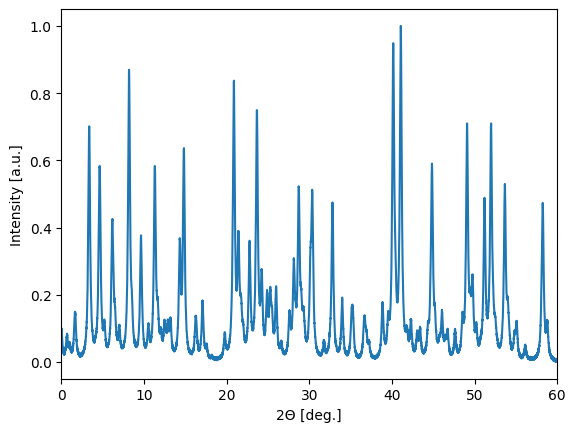

In [5]:
import matplotlib.pyplot as plt
xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
fig, ax = plt.subplots()
for i in range(1):
    plt.plot(xaxis_array,others[i])
plt.xlim(xaxis_min,xaxis_max)
plt.xlabel('2Θ [deg.]')
plt.ylabel('Intensity [a.u.]')
#plt.legend()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.show